In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Spécifique Arbre
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Chargement
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')
print("Données chargées.")

Données chargées.


In [2]:
# 1. Sélection des features (VERSION CORRIGÉE : On ne drop que ce qui existe)
X_raw = df.drop(['Attrition', 'Attrition_Numeric', 'EmployeeNumber'], axis=1)
y = df['Attrition_Numeric']

# 2. Encodage One-Hot
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# 3. Scaling (Optionnel pour les arbres, mais gardé pour la cohérence globale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# On remet en DataFrame
X = pd.DataFrame(X_scaled, columns=X_encoded.columns)

# Sauvegarde des noms de colonnes pour la prédiction
features_columns = X_encoded.columns.tolist()

print("--- Préparation terminée ---")
print(f"Nombre de features après encodage : {X.shape[1]}")

--- Préparation terminée ---
Nombre de features après encodage : 45


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Split terminé.")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Split terminé.
Train shape: (1084, 45)
Test shape: (272, 45)


In [4]:
# max_depth=4 permet d'éviter que l'arbre ne devienne trop complexe et illisible
model = DecisionTreeClassifier(random_state=42, max_depth=4)
model.fit(X_train, y_train)

print("Arbre de Décision entraîné.")

Arbre de Décision entraîné.


 BENCHMARK : ARBRE DE DÉCISION
Accuracy    : 0.7904
F1-Score    : 0.2400
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       225
           1       0.32      0.19      0.24        47

    accuracy                           0.79       272
   macro avg       0.58      0.55      0.56       272
weighted avg       0.75      0.79      0.77       272



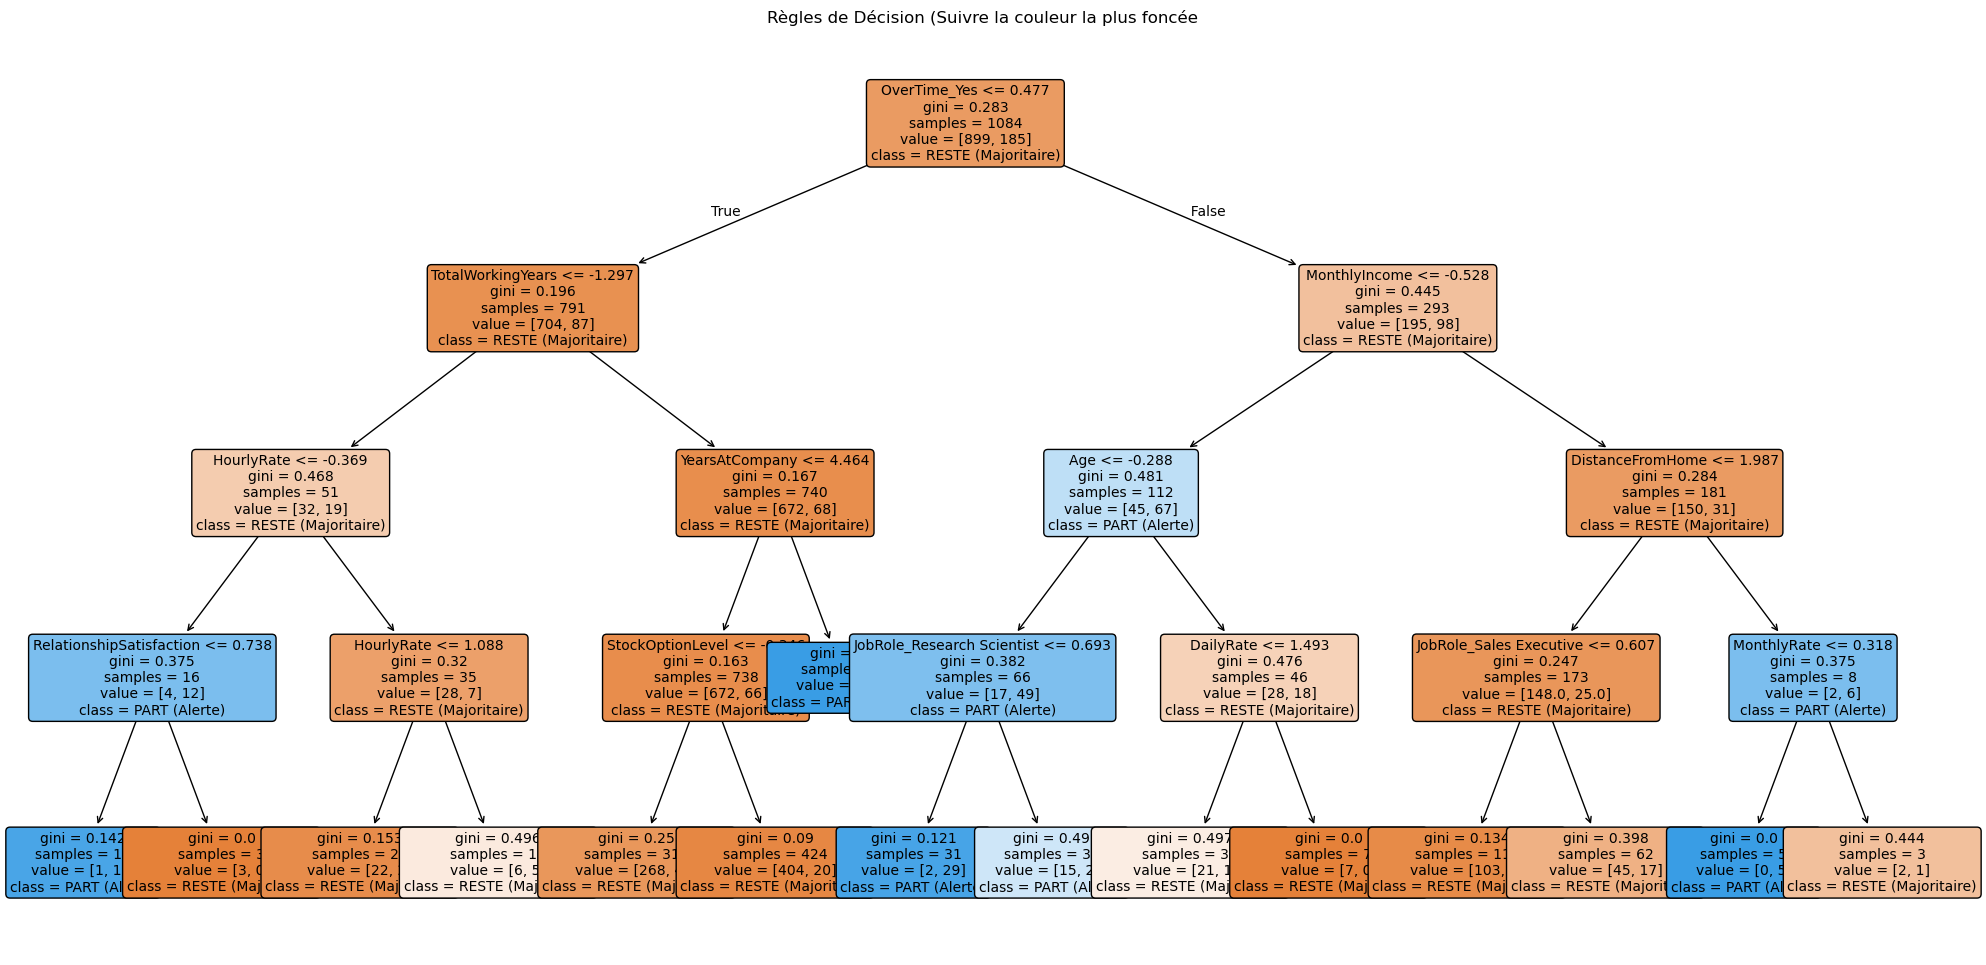

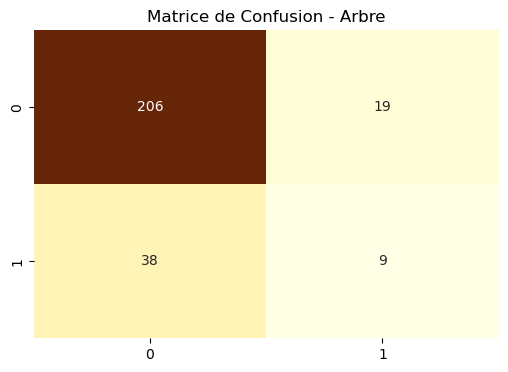

In [9]:
# Prédictions
y_pred = model.predict(X_test)

# Métriques
print("="*40)
print(" BENCHMARK : ARBRE DE DÉCISION")
print("="*40)
print(f"Accuracy    : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score    : {f1_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# --- GRAPHIQUE : L'Arbre ---
plt.figure(figsize=(25, 12)) # Très large pour bien voir
plot_tree(model, 
          feature_names=X.columns, 
          class_names=["RESTE (Majoritaire)", "PART (Alerte)"], 
          filled=True,
          rounded=True, 
          fontsize=10)
plt.title("Règles de Décision (Suivre la couleur la plus foncée")
plt.show()

# Matrice
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlOrBr', cbar=False)
plt.title("Matrice de Confusion - Arbre")
plt.show()

L'Arbre : C'est le seul modèle "lisible". Partez du haut.

-Chaque case est une question (ex: MonthlyIncome <= 2500 ?).

-Si Oui, allez à gauche. Si Non, allez à droite.

La couleur donne la conclusion :

🟠 ORANGE = Probable Rétention (L'employé va rester).

🔵 BLEU = Risque de Départ (Alerte !).

Plus la couleur est foncée, plus le modèle est sûr de lui (la règle est fiable).

In [6]:
def predire_demission(input_data, model, scaler, model_columns):
    # 1. Création DataFrame
    input_df = pd.DataFrame([input_data])
    
    # 2. Encodage
    input_encoded = pd.get_dummies(input_df)
    
    # 3. Alignement
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)
    
    # 4. Scaling
    input_scaled = scaler.transform(input_encoded)
    
    # 5. CORRECTION WARNING : Remettre en DataFrame
    input_scaled_df = pd.DataFrame(input_scaled, columns=input_encoded.columns)
    
    # 6. Prédiction
    proba = model.predict_proba(input_scaled_df)[0][1]
    prediction = "Va Partir (Risque)" if proba > 0.5 else "Va Rester"
    
    return prediction, proba

# Test
profil_employe = {
    'Age': 29, 'DailyRate': 400, 'DistanceFromHome': 25, 'EnvironmentSatisfaction': 1,
    'JobSatisfaction': 1, 'OverTime': 'Yes', 'Department': 'Sales', 'JobRole': 'Sales Executive'
}
resultat, proba = predire_demission(profil_employe, model, scaler, features_columns)
print(f"Profil Test : {profil_employe}")
print(f"Résultat : {resultat}")
print(f"Probabilité de départ : {proba:.2%}")

Profil Test : {'Age': 29, 'DailyRate': 400, 'DistanceFromHome': 25, 'EnvironmentSatisfaction': 1, 'JobSatisfaction': 1, 'OverTime': 'Yes', 'Department': 'Sales', 'JobRole': 'Sales Executive'}
Résultat : Va Partir (Risque)
Probabilité de départ : 93.55%


In [7]:
artefacts = {
    'model': model,
    'scaler': scaler,
    'features': features_columns
}
joblib.dump(artefacts, '../Models/modele_classif_tree.pkl')
print("Sauvegardé : '../Models/modele_classif_tree.pkl'")

Sauvegardé : '../Models/modele_classif_tree.pkl'


Conclusion :

 L'Arbre de Décision est légèrement moins précis que les modèles complexes, mais son graphique permet d'expliquer pourquoi une décision est prise (ex: "Si Heures Supp = Oui & Salaire < X, alors Départ"). C'est excellent pour la transparence.